# Fake or Real Text Detection: A Transformer Ensemble Model for a 91.493% Finish Score.

### This notebook demonstrates how I engineered a solution for a highly data-scarce NLP problem, combining traditional ML baselines with transformer ensembles to reach a final leaderboard score of 0.91493, ranking in the top 13%

## 🎯GOAL : 
### The primary challenge was to distinguish between texts  from a limited training set of 95 samples and both texts in each sample - real (optimal for the recipient, as close as possible to the hidden original text) and fake (more or much more distant from the hidden original text) - have been significantly modified using LLMs.

## Final Strategy
### My final strategy was to fine-tune a *DeBERTa-large* model using a semi-supervised approach with pseudo-labels generated by a powerful 5-model transformer ensemble. This approach successfully navigated the data scarcity issue by leveraging the large, unlabeled test set, yielding a final leaderboard score of 0.91493.

#### This approach was built upon the incredible work of the Kaggle community, integrating and inspired from several key ideas, like the [e.g., READX model ensemble] from the notebook by [omidbaghchehsaraei](https://www.kaggle.com/omidbaghchehsaraei) and advanced feature engineering concepts from [metawave](https://www.kaggle.com/metawave). This notebook documents how these concepts were combined and extended to create the final solution.More on Insipiration is at the end of this notebook.

# 🧑‍🍳 Strategies: 
### After initial experiments, a key insight emerged: training a "single-text scorer" model ,one that learns the absolute properties of a "real" vs. "fake" text and assigns each a score, consistently outperformed direct pairwise comparison methods. This was likely due to the small dataset size, as the scorer model's training data could be doubled and perfectly debiased.

## Summary of Approaches & Results
### While I experimented with numerous techniques, here is a summary of the most effective strategies in my journey.

## --- Machine Learning Only Approaches ---

### - *BaseLine* (TF-IDF with logistic Regression): 
This was my baseline/ first approach just to see with a normal and simple solution how much can a model learn. The model achieved a score of **0.778** on the leaderboard.This confirmed that while lexical features provided a strong signal, a more sophisticated approach would be required to capture the semantic and structural nuances.

### -*Ensemble of Baselines*: 
The underlying Principles are the same as the baseline but it uses predictions from 5 best machine learning models and it turned out to be logistic regression model with different Inverse Regularization (C) values. The final score from this was **0.84** this was a really good score considering how simple it is to many different models that i discussed later. *This proved lexical features alone weren’t enough.*

## --- Deep-Learning Only Approach ---

### - *BERT*: 
This was the simplest model to start from , just used the tokenizer from the bert model and trained it. The result was a positive **0.83195** score. This guided to me to move towards transformers architectures as they seem to learn better patterns here then simple machine learning models.

### - *Deberta with Psuedo-Labelling*: 
After Bert the most logical approach for me was to go for a bigger model(although i did many things in between) i.e. Deberta. Here I with the help of BERT model i did psuedo labelling of the test data and selected the labels (119) with confidence was more than 90%. This model made a score of **0.863**.*Hence Pseudo-labels gave a big boost despite limited true training data.*

## --- Hybrid Approaches ---

### - 🔍*Forensic Expert Model*: 
Here i did several data visualization and augmentation methods to create a rich feature set. The goal here was to squeeze as much information from the 95 samples as possible to. The Results were positive it had a score of **0.82** on the leaderboard, but not quite enough to beat the ensemble of Base Lines.Here i used 'gpt2' for perplexity, 'all-MiniLM-L6-v2' for Sentence-Coherence and 'Meta-Llama-3-8B-Instruct' for LLM Judge. This model had a final score of **0.82**

### - *Deberta with Baseline Ensemble (The 25-Day Champion)*: 
My best-performing solution for over three weeks was a hybrid blend. By taking a weighted average of the probabilities from the *DeBERTa-with-Pseudo-Labeling model* and *the Ensemble of Baselines*, I achieved a score of **0.88**. This "best of both worlds" approach proved to be a very powerful strategy.

## --- The Best Solution ---

### - *R_E_A_D_X Model*: 
The first breakthrough beyond 0.88 came from ensembling five diverse transformer architectures: **R**oBERTa, **E**LECTRA, **A**LBERT, **D**eBERTa, and **X**LNet. Training these models on the orginal 95 samples and averaging their probabilities yielded a score of **0.885**. 

### - 🏆*The Champion*: 
The final winning solution involved a form of knowledge distillation. The powerful READX ensemble was used as a "teacher" to generate 200 high-confidence pseudo-labels from the test set. A single DeBERTa-large model was then Pre-trained (higher learning rate) on the original data first and then fine-tuned(Lower Learning Rate) on these high-quality pseudo-labels with the original data . This "student" model learned the distilled knowledge of the entire ensemble, achieving the final best score of **0.91493**.
## --- Promising but not optimal Approaches---

### *DeBERTa with Domain Adaptation* :
An experiment was conducted to pre-train DeBERTa on the large, unlabeled test dataset before fine-tuning. This yielded a similar result to the standard fine-tuning, likely because the powerful - model adapted to the domain very quickly on its own.

### *The Champion with Reinforcement Learning*:
From the prediction probabilitues i had from the champion model it was obvserved that the model had many close calls where it miss labels by a 0.001 mark, By some Analysis i concluded that this happens when the texts are very similar to each other or they look very natural.A final experiment involved a custom training loop where the model was "punished" for being uncertain on unlabeled test data (entropy minimization). While a fascinating idea, this resulted in a slight diminishing return with a score of **0.881**, likely requiring a larger dataset to be truly effective.
### The Below is the sole reason for trying out this RL approach with the *Chapmpion Model*. As you can see the model had close calls for many datapoints (about 130 with <10% confidence and about 70 with <1% gap) making it predict certain datapoints by a small margin. This is about 10% of the test_set of 1000+ samples.

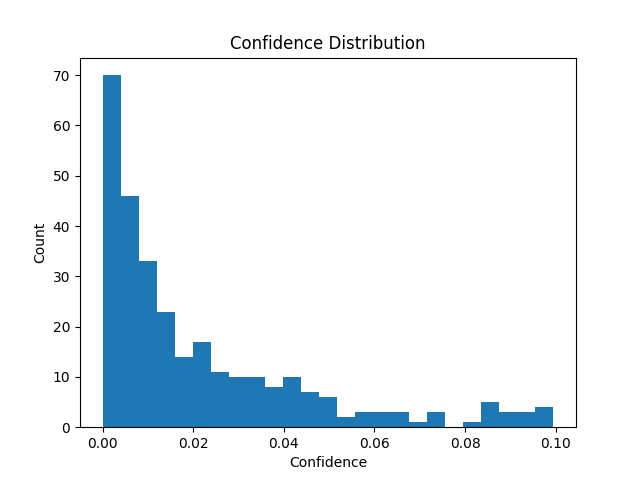

# Approach
### The following is the approach for Both the R_E_A_D_X as well as the Deberta Large Model,as these models are interlinked, hence it was essential to include them both.
Make Sure this [Public Dataset for Fake or Real: The imposter Hunt](https://www.kaggle.com/datasets/narayanprasaddas/public-dataset-for-fake-or-real-the-imposter-hunt) dataset is already added in the input directory,adding this to your input will make the code more seamless and easy to use, if not make sure you edit the path variables to your desired folders/paths.

## READX MODEL
This Step is not necessary to run you can jump to the final section where I processed and included the pseudo data generated from this step and just run the final step to see the results.

In [ ]:
import pandas as pd
import numpy as np
TEST_DATA_PATH = '/kaggle/input/public-dataset-for-fake-or-real-the-imposter-hunt/test_data.csv'
TRUE_TRAIN_DATA_PATH = '/kaggle/input/public-dataset-for-fake-or-real-the-imposter-hunt/train_dataset.csv'
# PSEUDO_TRAIN_DATA_PATH = ''
test_df = pd.read_csv(TEST_DATA_PATH)
train_df = pd.read_csv(TRUE_TRAIN_DATA_PATH)
# pseudo_train_data = pd.read_csv(PSEUDO_TRAIN_DATA_PATH)

In [ ]:
from sklearn.model_selection import train_test_split
aug_data = []
for _,row in train_df.iterrows():
    if row['labels']==1:
        aug_data.append({'text':row['text_1'],'label':1})
        aug_data.append({'text':row['text_2'],'label':0})
    else:
        aug_data.append({'text':row['text_1'],'label':0})
        aug_data.append({'text':row['text_2'],'label':1})
        
aug_data = pd.DataFrame(aug_data)
aug_data['text'] = aug_data['text'].fillna('')
train_df, val_df = train_test_split(aug_data, test_size=0.15, random_state=42, stratify=aug_data['label'])

In [ ]:
import tensorflow as tf
from transformers import AutoTokenizer,TFAutoModelForSequenceClassification,create_optimizer
from transformers import logging
import gc
tf.keras.mixed_precision.set_global_policy('mixed_float16')
logging.set_verbosity_error()
LR = 3e-5
MAX_TOKEN_LEN = 512
NUM_EPOCHS = 3
PATIENCE = 2  
SAVE_PATH = './best_models'
BATCH_SIZE = 2
STRATEGY = tf.distribute.MirroredStrategy()
original_weight = 1.0
pseudo_weight = 0.8  
WT_DECAY = 0.01
PRED_SAVE_PATH = './pred_proba'
MODEL_NAMES =[
    'google/electra-base-discriminator',
    'albert-base-v2',
    'microsoft/deberta-v3-base',
    'roberta-base',
    'distilbert-base-uncased'
]
SAVED_PATHS = []

In [ ]:
def pack_data(df,tokenizer,mode='eval'):
    print(f'Tokenizing Data...')
    encodings = tokenizer(
        df['text'].fillna('').tolist(),
        truncation=True,
        padding=True,
        max_length=MAX_TOKEN_LEN,
        return_tensors="tf"
    )
    if mode == 'eval':
        labels = df['label'].values
        dataset = tf.data.Dataset.from_tensor_slices((
            dict(encodings),
            labels
        ))
    else:
        dataset = tf.data.Dataset.from_tensor_slices((dict(encodings)))
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    return dataset

def train_model(model_name,path):
    patience_counter = 0
    best_val_loss = float('inf')
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    if 'deberta-v3' in model_name:
        tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
        
    train_dataset = pack_data(train_df,tokenizer)
    val_dataset = pack_data(val_df,tokenizer)
    
    with STRATEGY.scope():
        num_train_steps = len(train_df) * NUM_EPOCHS
        model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
        optimizer, _ = create_optimizer(init_lr=LR, 
                                            num_warmup_steps=int(0.1 * num_train_steps), 
                                            num_train_steps=num_train_steps,
                                            weight_decay_rate=WT_DECAY
                                        )
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
        model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
        
    safe_model_name = model_name.replace('/', '_')
    final_save_path = f'{SAVE_PATH}/{safe_model_name}'
    SAVED_PATHS.append(final_save_path)
    
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=1 
        )
        current_val_loss = history.history['val_loss'][0]
        if current_val_loss < best_val_loss:
            print(f"Validation loss improved from {best_val_loss:.4f} to {current_val_loss:.4f}. Saving model.")
            best_val_loss = current_val_loss
            
            print(f"Saving model to {final_save_path}")
            model.save_pretrained(final_save_path)
            tokenizer.save_pretrained(final_save_path)
            
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"Validation loss did not improve. Patience: {patience_counter}/{PATIENCE}")
    
        if patience_counter >= PATIENCE:
            print("Early stopping triggered. Training stopped.")
            break
    print("\n--- Training Finished ---")

In [ ]:
for model_name in MODEL_NAMES:
    print(f"Starting Training of {model_name} model...")
    try:
        train_model(model_name=model_name,path=SAVE_PATH)
    except RuntimeError as e:
        if "out of memory" in str(e).lower():
           print(f"Skipping {model_name} due to OutOfMemoryError.")
        else:
            raise e
    finally:
        print("Clearing session...")
        tf.keras.backend.clear_session()
        gc.collect()

In [ ]:
model_predictions = {}

test_df_text1 = test_df[['text_1']].rename(columns={'text_1': 'text'})
test_df_text2 = test_df[['text_2']].rename(columns={'text_2': 'text'})

for model_path in SAVED_PATHS:
    model_name = os.path.basename(model_path)
    print(f"Predicting with {model_name}...")
    model = TFAutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    
    test_dataset1 = pack_data(test_df_text1, tokenizer, mode='pred')
    logits1 = model.predict(test_dataset1).logits
    probs1 = tf.nn.softmax(logits1)[:, 1].numpy() 

    test_dataset2 = pack_data(test_df_text2, tokenizer, mode='pred')
    logits2 = model.predict(test_dataset2).logits
    probs2 = tf.nn.softmax(logits2)[:, 1].numpy() 

    model_predictions[f'{model_name}_prob1'] = probs1
    model_predictions[f'{model_name}_prob2'] = probs2

    tf.keras.backend.clear_session()
    gc.collect()


predictions_df = pd.DataFrame(model_predictions)
predictions_df['id'] = test_df['id'] 
PRED_SAVE_PATH = 'Readx_ensemble_test_predictions.csv'
predictions_df.to_csv(PRED_SAVE_PATH, index=False)
print(f"\nIndividual model predictions saved to {PRED_SAVE_PATH}")
print(predictions_df.head())


prob1_cols = [col for col in predictions_df.columns if '_prob1' in col]
prob2_cols = [col for col in predictions_df.columns if '_prob2' in col]

final_avg_probs_text1 = predictions_df[prob1_cols].mean(axis=1)
final_avg_probs_text2 = predictions_df[prob2_cols].mean(axis=1)

final_labels = np.where(final_avg_probs_text1 > final_avg_probs_text2, 1, 2)
def make_submission_csv(results):
    df_results = pd.DataFrame(results)
    output_df = df_results.copy()
    output_df.columns = ['real_text_id']
    output_df.reset_index(inplace=True)
    output_df.rename(columns={'index': 'id'}, inplace=True)
    output_df.to_csv('Deberta_Roberta_Electra_DisitilBERT_xlnet.csv', index=False)
    return output_df
pred_df = make_submission_csv(final_labels) # This Yielded a score of 0.885

## Data Processing
In this section the predictions from the readx model is made into a READX_top_200.csv which inlcuded the top 200 most confident labels in the test data. You can run this Step or you can directly jump to the next section where I included it in the input dataset.

In [ ]:
import pandas as pd
import numpy as np
PSUEDO_PROB_DATA_PATH = ''
pseudo_train_data = pd.read_csv(PSUEDO_PROB_DATA_PATH)
new_col_names = ['id','FTroberta-base_prob1','FTroberta-base_prob2','FTdeberta-v3-base_prob1','FTdeberta-v3-base_prob2',
                'FTelectra-base-discriminator_prob1','FTelectra-base-discriminator_prob2','FTalbert-base-v2_prob1',
                 'FTalbert-base-v2_prob2','FTxlnet-base-cased_prob1','FTxlnet-base-cased_prob2'
                ]
pseudo_train_data.drop(['Unnamed: 0'],axis=1,inplace=True)
cols = ['id'] + [col for col in pseudo_train_data.columns if col != 'id']
pseudo_train_data = pseudo_train_data[cols]
pseudo_train_data.columns = new_col_names

prob_1_cols = [col for col in pseudo_train_data.columns if '_prob1' in col]
prob_2_cols = [col for col in pseudo_train_data.columns if '_prob2' in col]

pseudo_train_data['avg_prob1'] = pseudo_train_data[prob_1_cols].mean(axis=1)
pseudo_train_data['std_prob1'] = pseudo_train_data[prob_1_cols].std(axis=1)
pseudo_train_data['avg_prob2'] = pseudo_train_data[prob_2_cols].mean(axis=1)
pseudo_train_data['std_prob2'] = pseudo_train_data[prob_2_cols].std(axis=1)

In [ ]:
CONFIDENCE_THRESH = 0.80
AGREEMENT_THRESH = 0.20
mask1  = (pseudo_train_data['avg_prob1'] > CONFIDENCE_THRESH) & (pseudo_train_data['avg_prob2'] < 1 - CONFIDENCE_THRESH)
mask2 = (pseudo_train_data['avg_prob2'] > CONFIDENCE_THRESH) & (pseudo_train_data['avg_prob1'] < 1 - CONFIDENCE_THRESH)
agreement_mask = (pseudo_train_data['std_prob1'] < AGREEMENT_THRESH) & (pseudo_train_data['std_prob2'] < AGREEMENT_THRESH)
high_confidence_pairs = pseudo_train_data[(mask1 | mask2) & agreement_mask]
pseudo_train_data['confidence_gap'] = (pseudo_train_data['avg_prob1'] - pseudo_train_data['avg_prob2']).abs()

pseudo_train_data_sorted = pseudo_train_data.sort_values(by='confidence_gap', ascending=False)
pseudo_train_data_sorted
top_confidence_pairs = pseudo_train_data_sorted.head(NUM_PSEUDO_PAIRS)

top_confidence_pairs['id'] = top_confidence_pairs['id'].astype('int64') 

print(top_confidence_pairs)
psuedo_label_dataset = pd.merge(test_df,
                                top_confidence_pairs,
                               left_on='id',
                               right_on='id',
                               how='inner')

psuedo_label_dataset
psuedo_label_dataset['label'] = np.where(psuedo_label_dataset['avg_prob1'] > psuedo_label_dataset['avg_prob2'], 1, 2)
psuedo_label_dataset = psuedo_label_dataset[['id', 'text_1', 'text_2', 'label']]
psuedo_label_dataset.to_csv('READX_top_200.csv')
print("Final Pseudo-Labeled DataFrame and made READX_top_200.csv :")
psuedo_label_dataset

# 🏆 The Champion
This Part includes the pseudo labelled data from the Readx model, You can use it directly from the input dataset i provided or you can run those 5 models first and then use it.

> **⚠️NOTE**: Before Running this step If you have run and trained the previous models make sure to *Restart and Clear Cell Outputs* to avoid any potential Memory Overflow issues.

> Also this Section is broadly divided into 4 parts, i would again highly recommend to run the pre-training , fine-tuning and test step seprately to avoid memory overflow,each time you use *Restart and Clear Cell Outputs* make sure to **re-run Data Augementation and Functions** part to avoid erros.

## Data Augementation and Functions


In [ ]:
# Hyper Parameters
import tensorflow as tf
from transformers import AutoTokenizer,TFAutoModelForSequenceClassification,create_optimizer,AutoConfig
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
LR = 1.5e-5
MAX_TOKEN_LEN = 256
NUM_EPOCHS = 2
PATIENCE = 2  
BATCH_SIZE = 1
ORIGINAL_WEIGHT = 1.0
PSEUDO_WEIGHT = 0.6
WT_DECAY = 0.1
CONFIDENCE_THRESH = 0.85 
AGREEMENT_THRESH = 0.10
NUM_PSEUDO_PAIRS = 200
STRATEGY = tf.distribute.MirroredStrategy()
TEST_DATA_PATH = '/kaggle/input/public-dataset-for-fake-or-real-the-imposter-hunt/test_data.csv'
TRUE_TRAIN_DATA_PATH = '/kaggle/input/public-dataset-for-fake-or-real-the-imposter-hunt/train_dataset.csv'
PSEUDO_TRAIN_DATA_PATH = '/kaggle/input/public-dataset-for-fake-or-real-the-imposter-hunt/READX_top_200.csv'
MODEL_NAME = 'microsoft/deberta-v3-large'
SAVE_PATH = f'./best_model'
PRED_SAVE_PATH = './pred_proba'
SAVED_PATHS = []

In [ ]:
def augment_data(df):
    if 'label' in df.columns:
        df['labels'] = df['label']
    real_texts = pd.concat([
        df.loc[df['labels'] == 1, 'text_1'],
        df.loc[df['labels'] == 2, 'text_2']
    ])
    fake_texts = pd.concat([
        df.loc[df['labels'] == 1, 'text_2'],
        df.loc[df['labels'] == 2, 'text_1']
    ])
    df_real = pd.DataFrame({'text': real_texts, 'label': 1})
    df_fake = pd.DataFrame({'text': fake_texts, 'label': 0})
    aug_data = pd.concat([df_real, df_fake], ignore_index=True)
    aug_data = aug_data.sample(frac=1).reset_index(drop=True)
    return aug_data
test_df = pd.read_csv(TEST_DATA_PATH)
train_df = pd.read_csv(TRUE_TRAIN_DATA_PATH)
pseudo_train_data = pd.read_csv(PSEUDO_TRAIN_DATA_PATH)

train_df_, val_df = train_test_split(train_df, 
                                     test_size=0.30, 
                                     random_state=42, 
                                     stratify=train_df['labels'])
aug_train_df = augment_data(train_df_)
val_df = augment_data(val_df)
aug_psuedo_train_df = augment_data(pseudo_train_data)
aug_train_df['source'] = 'original'
aug_psuedo_train_df['source'] = 'pseudo'
joint_train_df = pd.concat([aug_train_df,aug_psuedo_train_df],ignore_index=True)
joint_train_df['sample_weight'] = np.where(
    joint_train_df['source'] == 'original', 
    ORIGINAL_WEIGHT,      
    PSEUDO_WEIGHT     
)
joint_train_df = joint_train_df.sample(frac=1).reset_index(drop=True)

In [ ]:
def pack_data(df,tokenizer,mode='train'):
    print(f'Tokenizing Data...')
    cols = df.columns
    encodings = tokenizer(
        df['text'].fillna('').tolist(),
        truncation=True,
        padding=True,
        max_length=MAX_TOKEN_LEN,
        return_tensors="tf"
    )
    if 'sample_weight' in cols:
        labels = df['label'].values
        weights = df['sample_weight'].values
        dataset = tf.data.Dataset.from_tensor_slices((
            dict(encodings),
            labels,
            weights
        ))
    elif 'labels' or 'label' in cols:
        labels = df['label'].values
        dataset = tf.data.Dataset.from_tensor_slices((
            dict(encodings),
            labels,
        ))
    else:
        dataset = tf.data.Dataset.from_tensor_slices((dict(encodings)))
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset
from transformers import logging
import gc
tf.keras.mixed_precision.set_global_policy('mixed_float16')
logging.set_verbosity_error()
def train_model(model_name,
                train_df,
                val_df,
                path,
                config):
    patience_counter = 0
    best_val_loss = float('inf')
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    if 'deberta-v3' in model_name:
        tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
        
    train_dataset = pack_data(train_df,tokenizer,mode='train')
    val_dataset = pack_data(val_df,tokenizer,mode='val')
    
    with STRATEGY.scope():
        num_train_steps = len(train_df) * NUM_EPOCHS
        model = TFAutoModelForSequenceClassification.from_pretrained(model_name,
                                                                     config=config)
        optimizer, _ = create_optimizer(init_lr=LR, 
                                            num_warmup_steps=int(0.1 * num_train_steps), 
                                            num_train_steps=num_train_steps,
                                            weight_decay_rate=WT_DECAY
                                        )
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
        model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
        
    safe_model_name = model_name.replace('/', '_')
    final_save_path = f'{SAVE_PATH}/{safe_model_name}'
    SAVED_PATHS.append(final_save_path)
    
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=1 
        )
        current_val_loss = history.history['val_loss'][0]
        if current_val_loss < best_val_loss:
            print(f"Validation loss improved from {best_val_loss:.4f} to {current_val_loss:.4f}. Saving model.")
            best_val_loss = current_val_loss
            
            print(f"Saving model to {final_save_path}")
            model.save_pretrained(final_save_path)
            tokenizer.save_pretrained(final_save_path)
            
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"Validation loss did not improve. Patience: {patience_counter}/{PATIENCE}")
    
        if patience_counter >= PATIENCE:
            print("Early stopping triggered. Training stopped.")
            break
    print("\n--- Training Finished ---")


## Pre-Training Step

In [ ]:
config = AutoConfig.from_pretrained(MODEL_NAME)
config.classifier_dropout = 0.1 
config.num_labels = 2
train_model(model_name=MODEL_NAME,
            train_df=aug_train_df,
            val_df=val_df,
            path=SAVE_PATH,
            config=config
           )

## Fine-Tuning-Step

In [ ]:
SAVED_PATHS = ['./best_models/microsoft_deberta-v3-large']

SAVE_PATH = SAVE_PATH+'_fine_tuned'
LR = 5e-6
config = AutoConfig.from_pretrained(SAVED_PATHS[0])
config.classifier_dropout = 0.1 
config.num_labels = 2
train_model(
            model_name=SAVED_PATHS[0],
            train_df=joint_train_df,
            val_df=val_df,
            path=SAVE_PATH,
            config=config
            )

## Test-Step

In [ ]:
CURR_SAVE_PATHS = ['./best_models_fine_tuned_fine_tuned/._best_models_microsoft_deberta-v3-large']
test_df_text1 = test_df[['text_1']].rename(columns={'text_1': 'text'})
test_df_text2 = test_df[['text_2']].rename(columns={'text_2': 'text'})
model_predictions = {}
tf.keras.mixed_precision.set_global_policy('mixed_float16')
for model_path in CURR_SAVE_PATHS:
    print(f'---------------predicting with saved model{model_path}---------------')
    print('---------------Loading Model and Tokenizer---------------')
    with STRATEGY.scope():
        model = TFAutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    print('---------------Tokenizing and Predicting on Text1---------------')
    
    test_dataset1 = pack_data(test_df_text1, tokenizer, mode='pred')
    logits1 = model.predict(test_dataset1).logits
    probs1 = tf.nn.softmax(logits1)[:, 1].numpy() 
    
    print('---------------Tokenizing and Predicting on Text2---------------')
    test_dataset2 = pack_data(test_df_text2, tokenizer, mode='pred')
    logits2 = model.predict(test_dataset2).logits
    probs2 = tf.nn.softmax(logits2)[:, 1].numpy() 

    model_predictions[f'{model_path}_prob1'] = probs1
    model_predictions[f'{model_path}_prob2'] = probs2
    print('---------------Finished Model Predictions---------------')
    tf.keras.backend.clear_session()
    gc.collect()
predictions_df = pd.DataFrame(model_predictions)
predictions_df['id'] = test_df['id'] 
# PRED_SAVE_PATH = 'deberta(0.91493)_large_test_predictions.csv'
predictions_df.to_csv(PRED_SAVE_PATH, index=False)
print(f"\nIndividual model predictions saved to {PRED_SAVE_PATH}")
print(predictions_df.head())

prob1_cols = [col for col in predictions_df.columns if '_prob1' in col]
prob2_cols = [col for col in predictions_df.columns if '_prob2' in col]

final_avg_probs_text1 = predictions_df[prob1_cols].mean(axis=1)
final_avg_probs_text2 = predictions_df[prob2_cols].mean(axis=1)

final_labels = np.where(final_avg_probs_text1 > final_avg_probs_text2, 1, 2)
def make_submission_csv(results,name=None):
    df_results = pd.DataFrame(results)
    output_df = df_results.copy()
    output_df.columns = ['real_text_id']
    output_df.reset_index(inplace=True)
    output_df.rename(columns={'index': 'id'}, inplace=True)
    if name!=None:
        output_df.to_csv(name, index=False)
    return output_df
pred_df = make_submission_csv(final_labels,name='Deberta_large_on_READX_200.csv')

# Learnings 

### There is a lot that i learned in this journey, in the beginning i was able to build ML models but this Competition inspired me to learn a lot of NLP. From Various Data Augmentation techniques to finetuning a large model , i Learned a lot, and here are the few key things i learned:

- Baselines Matter: Simple models like TF-IDF + Logistic Regression gave surprisingly strong starting points.
- Scarcity Hacks: With only 95 samples, creative techniques (pseudo-labelling, augmentation) were essential.
- Pseudo-Labels : Using confident test predictions as training data boosted performance significantly.
- Data-spliting : Learned not only about train-test-split but also about groupkfolds, strategies in splitting data with key values.
- Power of Ensembling /Stacking : Combining multiple models captured diverse patterns better than any single model, also may a times stacking models seems to work better than ensembles.
- Hybrid Wins : Blending ML features with transformer predictions outperformed either alone.
- Progressive Scaling : Moving from small (BERT) to larger (DeBERTa-Large) models gave incremental gains.
- Confidence Filtering : Selecting only high-confidence pseudo-labels avoided noise and improved stability.
- Custom Loss Insight : Tried reinforcement-style loss adjustments—showed potential but limited by data.
- Interpretability Attempts : Features like perplexity and coherence added human-style checks, though not always better than pure models.

- Iteration Counts : Improvement came step by step; no single “magic trick,” but layering ideas carefully.
### This Competition was an intense sprint for me, completed in just under 4 weeks after joining the competition late. While there are always more avenues to explore, I am satisfied of the robust and high-performing pipeline that I developed in this limited timeframe and looking forward to applying these learnings to future challenges and projects.

# Acknowledgements & Inspirations

### This journey would not have been possible without the amazing Kaggle community. I learned a great deal from public notebooks, studying how other data scientists approach and solve complex problems with clever and effective techniques. My sincere thanks to the entire community and to the organizers for hosting this fantastic competition.
### In particular, I'd like to acknowledge the following inspirations:
- My perplexity and LLM judge idea is inspired from [This Notebook](https://www.kaggle.com/code/metawave/memory-optimized-transformers-for-impostor-hunt)
- MY READX model was an direct inspiration from [This Notebook](https://www.kaggle.com/code/omidbaghchehsaraei/averaging-ensembling-for-the-impostor-hunt-in-text/notebook)